### Leonardo Ji
#### Example notebook break downs to four sections:
* EDA
* Feature Engineering
* Feature Selections
* Modeling

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import warnings
from scipy.stats import pearsonr

### EDA

In [227]:
diet_df = pd.read_csv('../data/diet_data.csv')
print(diet_df.shape)
diet_df.head()

(151, 14)


,Date,Stone,Pounds,Ounces,weight_oz,calories,cals_per_oz,five_donuts,walk,run,wine,prot,weight,change
0,7/30/2018,12.0,2.0,6.0,2726.0,1950.0,0.72,1.0,1.0,0.0,0.0,0.0,0.0,-30.0
1,7/31/2018,12.0,0.0,8.0,2696.0,2600.0,0.96,1.0,0.0,0.0,0.0,0.0,0.0,8.0
2,8/1/2018,12.0,1.0,0.0,2704.0,2500.0,0.92,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,8/2/2018,12.0,1.0,0.0,2704.0,1850.0,0.68,1.0,1.0,0.0,1.0,0.0,0.0,-40.0
4,8/3/2018,11.0,12.0,8.0,2664.0,2900.0,1.09,1.0,1.0,0.0,0.0,0.0,0.0,14.0


In [228]:
for col in diet_df.columns:
    print(col, ' ', diet_df[col].dtype)

Date   object
Stone   float64
Pounds   float64
Ounces   float64
weight_oz   float64
calories   float64
cals_per_oz   object
five_donuts   float64
walk   float64
run   float64
wine   float64
prot   float64
weight   float64
change   float64


In [229]:
diet_df['Date'] = pd.to_datetime(diet_df['Date'])

In [230]:
missing_df = diet_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df.tail()

,column_name,missing_count
8,walk,11
9,run,11
10,wine,11
11,prot,11
12,weight,11


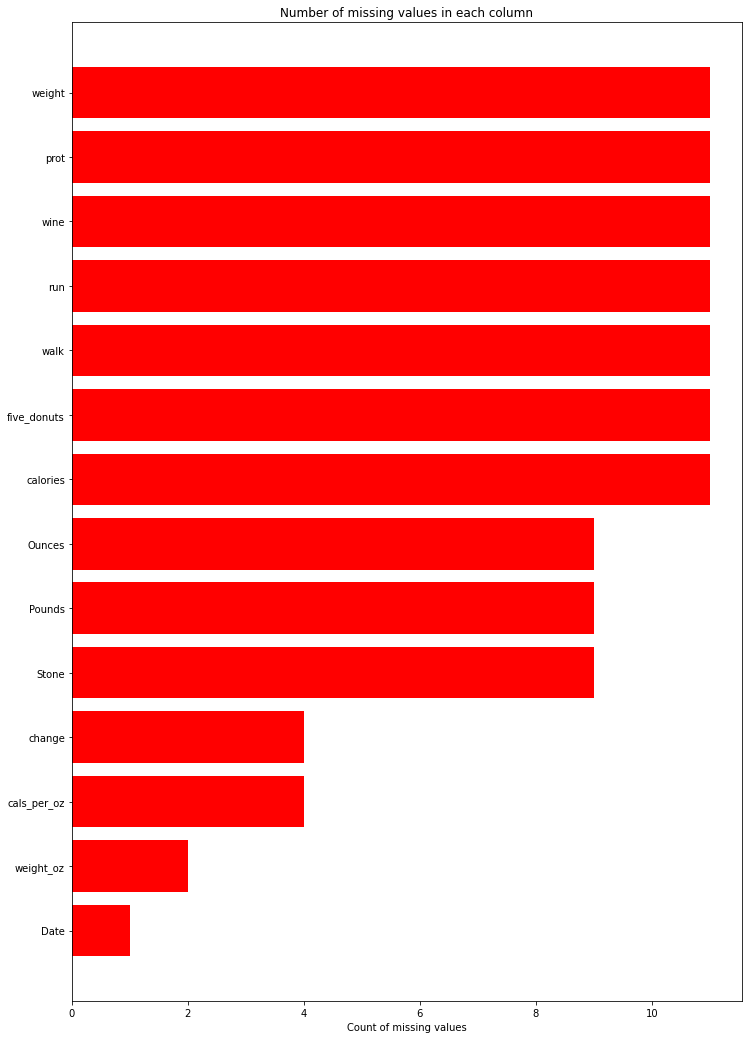

In [231]:
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='red')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [232]:
diet_df.dropna(subset=['Date', 'weight_oz', 'weight'], inplace=True)
diet_df.shape

(140, 14)

In [233]:
bin_cols = [col for col in diet_df if diet_df[col].value_counts().index.isin([0, 1]).all()]
bin_cols

['five_donuts', 'walk', 'run', 'wine', 'prot', 'weight']

In [234]:
# exclude date, target related columns
exclude = ['Date', 'change', 'weight_oz', 'Stone', 'Pounds', 'Ounces', 'cals_per_oz'] + bin_cols
cont_cols = [col for col in diet_df.columns.tolist() if col not in exclude]
cont_cols

['calories']

In [235]:
medians = diet_df[cont_cols].median().to_dict()
diet_df[cont_cols] = diet_df[cont_cols].fillna(medians)

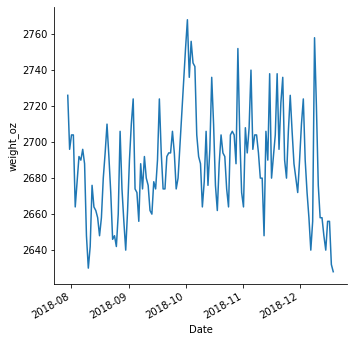

In [236]:
g = sns.relplot(x="Date", y="weight_oz", kind="line", data=diet_df)
g.figure.autofmt_xdate()

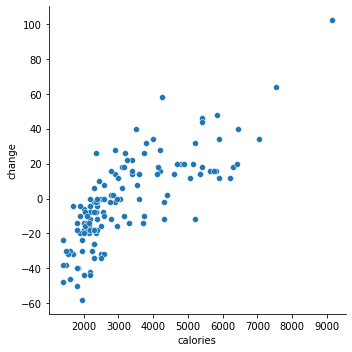

In [237]:
sns.relplot(x=diet_df.calories, y=diet_df.change)

### Feature Engineering

In [238]:
# find columns with less than 0.01% prevalence
threshold = 0.001

cols_drop = []
for col in bin_cols:
    if(diet_df[col].sum() / diet_df.shape[0] < threshold):
        cols_drop.append(col)
        
## drop columns below threshold
print(diet_df.shape)
print(cols_drop)
diet_df.drop(cols_drop, axis = 1, inplace=True)
print(diet_df.shape)

(140, 14)
[]
(140, 14)


In [239]:
def _corr(df_, threshold = 0.95, impute = 0, keep=[]):
    '''
    A function to find the ocrrelated variables
    inputs :
            df : dataframe
            threshold : correlation threshold value as a cut-off
            impute : string for dataframes with Null values : can be "mean" and "median"
                     If nothing passes, it will be None. Pandas by default drops the null values
    output : pruned dataframe
    '''
    # check for imputation
    if(impute == "median"):
        df = df_.copy()
        df.fillna(df.median(), inplace = True)
    elif(impute == "mean"):
        df = df_.copy()
        df.fillna(df.mean(), inplace = True)
    else:
        df = df_.copy()
        
        
    # pair-wised correlation:
        # methods can be pearosn, kendall, and spearman
        # min_periods sets the minimum number of observation for each feature
    corr = df.corr(method = "pearson", min_periods = 1)
    
    # mean of absoulte value of the of each column of the correlation matrix
    mean_corr_col = abs(corr).mean(axis = 1)
    
    # empty list for adding correlated columns
    correlated_cols = []
    for i in range(len(corr)):
        for j in range(len(corr)):
            # skip this round if one of them is already removed
            if(i != j and corr.iloc[i,j] > threshold and corr.columns[i] not in correlated_cols and corr.columns[j] not in correlated_cols):
            
                if (corr.columns[j] in keep):
                    correlated_cols.append(corr.columns[i])
                    print('Keep: ',corr.columns[j], ' Remove: ',corr.columns[i])
                elif (mean_corr_col[i] >= mean_corr_col[j]):
                    correlated_cols.append(corr.columns[i])
                    print('Keep: ',corr.columns[j], mean_corr_col[j], ' Remove: ',corr.columns[i], mean_corr_col[i])
                    
    # dropping correlated features
    drops = list(set(correlated_cols))
    print('Dropping below: ', drops)
    df_pruned = df.drop(drops, axis = 1)
    
    return df_pruned

In [240]:
diet_df = _corr(diet_df, threshold = 0.80, impute = 0, keep=['weight_oz','weight','change'])
print(diet_df.shape)

Dropping below:  []
(140, 14)


### Feature Selection

In [241]:
# add random shuffled columns for feature selection threshold later
from sklearn.utils import shuffle
def permute(df, exclude=[]):
    """
    a funtion to permute the rows of features and add them
    to the dataframe as noisy features to explore stability
    """
    ids = [col for col in df.columns.tolist() if col not in exclude]
    noisy_df = df.loc[:, ids].copy()
    noisy_df.rename(columns = {col : "random_" + col for col in noisy_df.columns}, inplace = True)
    noisy_df = noisy_df.reindex(shuffle(noisy_df.index)).reset_index(drop = True)
    merged_df = pd.concat([df.reset_index(drop = True), noisy_df] , axis = 1)
    return merged_df

diet_df.shape
print(diet_df.shape)

df = permute(diet_df, ['Date', 'change', 'weight_oz', 'Stone', 'Pounds', 'Ounces', 'cals_per_oz'])
df.shape

(140, 14)


(140, 21)

In [242]:
# separate features to binary and continuous features

cols = [col for col in df.columns.tolist() if col not in ['Date', 'change', 'weight_oz', 'Stone', 'Pounds', 'Ounces', 'cals_per_oz']]
features = df.loc[:, cols]
bin_cols = [col for col in features if features[col].value_counts().index.isin([0, 1]).all()]
cont_cols = [col for col in features.columns.tolist() if col not in bin_cols]
print(len(bin_cols))
print(len(cont_cols))

12
2


In [243]:
## create tes-train split
X=df[bin_cols]
Y=df['change']
## print df shape
print(X.shape)
print(Y.shape)

(140, 12)
(140,)


In [244]:
# import xgboost as xg

# dtrain = xgb.DMatrix(data = X, label = Y)
# xgb_params = {"eval_metric" : "rmse",
#                   "tree_method": "hist",
#                   "objective" : "reg:squarederror",
#                   "max_delta_step": 1,
#                   "nthread" : 1,
#                   "scale_pos_weight" : 1,
#                   "reg_alpha" : 0.0,
#                   "reg_lambda" : 1.0,
#                   "learning_rate" : 0.05,
#                   "max_depth": 2,
#                   "min_child_weight": 5,
#                   "gamma" : 0.0,
#                   "subsample" : 1.0,
#                   "colsample_bytree" : 0.9 
#                  }
# bst = xgb.train(params = xgb_params,
#                     dtrain = dtrain,
#                     num_boost_round = 10)


from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV

xgb_rf = XGBRFRegressor()

param_grid = {
    'bootstrap': [True],
    'oob_score': [True],
    'n_estimators': [10]
}
  
xgb_grid_search = GridSearchCV(estimator = xgb_rf, param_grid = param_grid, 
                           cv = 10, verbose = 2)
xgb_grid_search.fit(X, Y);


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[00:16:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "bootstrap", "oob_score" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END ....bootstrap=True, n_estimators=10, oob_score=True; total time=   0.0s
[00:16:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "bootstrap", "oob_score" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END ....bootstrap=True, n_estimators=10, oob_scor

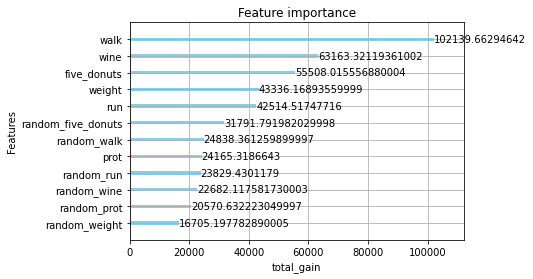

In [245]:
from xgboost import plot_importance

plot_importance(xgb_grid_search.best_estimator_, importance_type = "total_gain", color = "skyblue", xlabel = "total_gain")
plt.show()   

In [246]:
cont_cols

['calories', 'random_calories']

In [247]:
## create tes-train split
X=df[cont_cols]
Y=df['change']
## print df shape
print(X.shape)
print(Y.shape)

(140, 2)
(140,)


In [248]:

from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV

xgb_rf = XGBRFRegressor()

param_grid = {
    'bootstrap': [True],
    'oob_score': [True],
    'n_estimators': [10]
}
  
xgb_grid_search = GridSearchCV(estimator = xgb_rf, param_grid = param_grid, 
                           cv = 10, verbose = 2)
xgb_grid_search.fit(X, Y);


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[00:16:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "bootstrap", "oob_score" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END ....bootstrap=True, n_estimators=10, oob_score=True; total time=   0.0s
[00:16:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "bootstrap", "oob_score" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END ....bootstrap=True, n_estimators=10, oob_scor

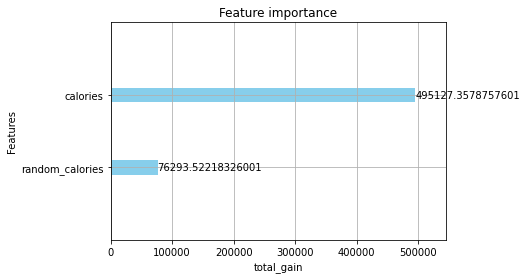

In [249]:
from xgboost import plot_importance

plot_importance(xgb_grid_search.best_estimator_, importance_type = "total_gain", color = "skyblue", xlabel = "total_gain")
plt.show()   

### Modeling

In [253]:
features = ['calories', 'walk', 'run', 'wine', 'five_donuts']
means = diet_df[features].mean().to_dict()
means

{'calories': 3180.714285714286,
 'walk': 0.6785714285714286,
 'run': 0.25,
 'wine': 0.30714285714285716,
 'five_donuts': 0.37142857142857144}

In [254]:
stds = diet_df[features].std().to_dict()
stds

{'calories': 1478.753433247481,
 'walk': 0.46870182177899816,
 'run': 0.4345675101331315,
 'wine': 0.4629655513611933,
 'five_donuts': 0.48492166752809907}

In [255]:
target = diet_df.change
date = diet_df.Date

# Normalize the all matrix
df = (diet_df[features] - means)/stds
df.fillna(0, inplace=True)


# add back after normalization
df.loc[:,'target'] = target
df.loc[:,'Date'] = date

In [257]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=.3, shuffle=False, random_state=None)
X_train, X_test = train[features], test[features]
y_train, y_test = train['target'], test['target']

In [277]:
from sklearn.metrics import mean_squared_error as MSE

# Instantiation
xgb_params = {"eval_metric" : "rmse",
                  "tree_method": "hist",
                  "objective" : "reg:squarederror",
                  "n_estimators": 10
                 }
xgb_r = xg.XGBRegressor(params = xgb_params, seed = 123)
  
# Fitting the model
xgb_r.fit(X_train, y_train)
  
# Predict the model
pred = xgb_r.predict(X_test)
  
# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

[00:32:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


RMSE :  23.183938
